In [1]:
import numpy as np
import healpy as hp
from astropy.table import Table
import matplotlib.pyplot as plt
from astropy.coordinates import SkyCoord, Galactic

Message from Josh:

Ok, so by trial and error, it looks like the RVS files are coded by HEALPix pixel with nside=8, which can be recovered from the DR3 source_id via:

dr3_source_id/(long64(2))^(59-2*8)


In [2]:
def lat2theta(lat): return np.radians(90. - lat)
def lon2phi(lon): return np.radians(lon)
def ang2pix(lon, lat, nside=256):
    theta = lat2theta(lat)
    phi = lon2phi(lon)
    return hp.ang2pix(nside, theta, phi)
def theta2lat(theta): return 90 - 180*theta/np.pi
def phi2lon(phi): return 180/np.pi * phi
def pix2ang(pix, nside=256):
    theta, phi =  hp.pix2ang(nside, pix)
    lat = theta2lat(theta)
    lon = phi2lon(phi)
    return lon, lat

ra = 0.9
dec= 70.0
pix = ang2pix(ra, dec)
print(pix)
print(pix2ang(pix))

23545
(1.238532110091743, 69.97948672013831)


In [3]:
hp.order2nside(8)

256

In [4]:
hp.nside2npix(256)

786432

In [5]:
with open("_MD5SUM.txt","r") as fp:
    fnames = [l.strip().split()[1] for l in fp.readlines()]

In [6]:
hp1s = [x.split("_")[1].split("-")[0] for x in fnames]
hp2s = [x.split("_")[1].split("-")[1].split(".")[0] for x in fnames]
# for x,y,z in zip(hp1s, hp2s, fnames):
#     print(x,y,z)

In [7]:
nside = 256
npix = hp.nside2npix(nside)

In [8]:
ipix = np.arange(npix)
ifname = []
for x,y,z in zip(hp1s, hp2s, fnames):
    x,y = int(x), int(y)
    N = y - x + 1
    ifname += [z]*N
print(len(ifname), npix)
# this is theta, phi coordinates
icoo = np.vstack(pix2ang(ipix, nside))

786432 786432


In [9]:
tab = Table([ipix, ifname, icoo[0], icoo[1]],
           names=["ipix","fname","RA","Dec"])
coo = SkyCoord(tab["RA"], tab["Dec"], unit="deg")
gcoo = coo.transform_to(Galactic)
tab["l"] = gcoo.l.deg
tab["b"] = gcoo.b.deg

In [10]:
np.min(tab["RA"]), np.max(tab["RA"])

(0.0, 359.82421875)

In [11]:
np.min(tab["Dec"]), np.max(tab["Dec"])

(-89.81725848475486, 89.81725848475484)

In [12]:
tab

ipix,fname,RA,Dec,l,b
int64,str45,float64,float64,float64,float64
0,XpContinuousMeanSpectrum_000000-003111.csv.gz,45.0,89.81725848475484,123.04100977548256,26.973474664347844
1,XpContinuousMeanSpectrum_000000-003111.csv.gz,135.0,89.81725848475484,123.10593917214287,27.225363193729343
2,XpContinuousMeanSpectrum_000000-003111.csv.gz,225.0,89.81725848475484,122.82253844255101,27.28294564955499
3,XpContinuousMeanSpectrum_000000-003111.csv.gz,315.0,89.81725848475484,122.75821362945506,27.030927532626976
4,XpContinuousMeanSpectrum_000000-003111.csv.gz,22.5,89.63451650477154,123.00047706765736,26.767913706973847
5,XpContinuousMeanSpectrum_000000-003111.csv.gz,67.5,89.63451650477154,123.26620321292486,26.916349937064734
6,XpContinuousMeanSpectrum_000000-003111.csv.gz,112.5,89.63451650477154,123.3370074093051,27.188877282548724
7,XpContinuousMeanSpectrum_000000-003111.csv.gz,157.5,89.63451650477154,123.17021368989592,27.426116602981715
...,...,...,...,...,...


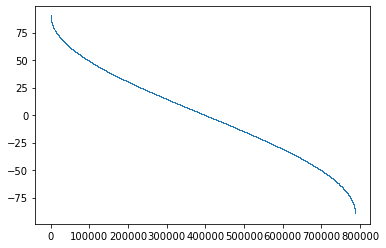

In [13]:
plt.plot(tab["ipix"], tab["Dec"], ',')

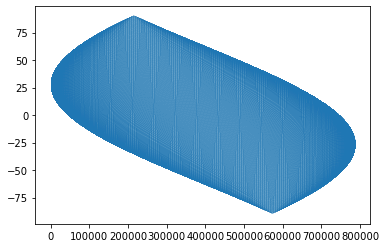

In [14]:
plt.plot(tab["ipix"], tab["b"], ',', alpha=.1)

In [15]:
np.sum(np.abs(tab["b"]) > 30), len(tab)

(393234, 786432)

In [16]:
np.unique(tab[np.abs(tab["b"]) > 20]["fname"]).size, len(np.unique(tab["fname"]))

(2685, 3386)

In [17]:
3386-2685

701

In [18]:
sizes = Table.read("XpSize.txt", format="ascii.fixed_width_two_line")

In [19]:
np.sum(~np.isin(tab["fname"], sizes["fname"]))


0

In [20]:
total_size = np.sum(sizes["size"])
ii = np.abs(tab["b"]) > 20
b20_size = np.sum(sizes["size"][np.isin(sizes["fname"], tab[ii]["fname"])])
ii = np.abs(tab["b"]) > 30
b30_size = np.sum(sizes["size"][np.isin(sizes["fname"], tab[ii]["fname"])])
ii = np.abs(tab["b"]) > 40
b40_size = np.sum(sizes["size"][np.isin(sizes["fname"], tab[ii]["fname"])])
print(f"{total_size}, {b20_size/total_size:.2f}, {b30_size/total_size:.2f}, {b40_size/total_size:.2f}")

3609790342836, 0.84, 0.73, 0.60
